In [64]:
import numpy as np
import pandas as pd
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import joblib

In [65]:
# ===============================
# CONFIG
# ===============================
DATA_DIR = Path("data")
MODEL_DIR = Path("serialized")
MODEL_DIR.mkdir(exist_ok=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

T_CONTEXT = 24 * 3 # 3 дні
HORIZON   = 6 # 6 годин вперед
BATCH_SIZE = 128
EPOCHS = 15


Прогнозувати будемо energy_deficit_adj(t+1…t+6) погодинно, по регіонах. Контекстне вікно 3 дня

список фіч:
"demand_ua_adj","generation_ua_adj","energy_deficit_adj","alert_active", "isDamaged", "temperature","humidity","precipitation","snowfall","wind_speed","wind_gusts","cloud_cover","surface_pressure",

P.S. 25лямів рядків вийшло +- 1гб

Година доби - циклічна змінна (23.00->00.00), нейромережа бачить різкий розрив, якого фізично не існує, тому модель не буде розуміти добових патернів. Для цього робимо проекцію на коло - представляємо годину як точку на одиничному колі, тоді 23 та 00 будуть не далеко як до цього, а поруч один до одного, тобто модель бачить добовий цикл. робимо це через синуси та косинуси)

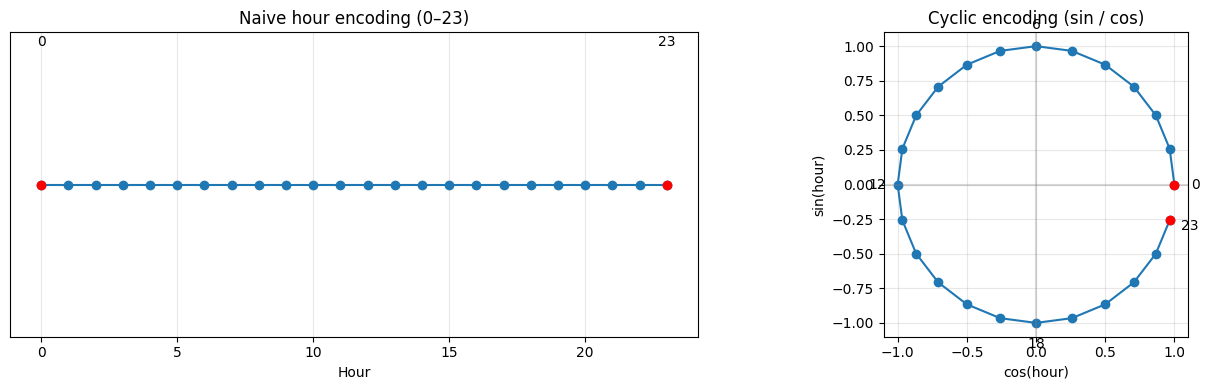

In [66]:
import matplotlib.pyplot as plt

hours = np.arange(24)

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(hours, np.zeros_like(hours), "o-")
axes[0].scatter([23, 0], [0, 0], color="red", zorder=5)

axes[0].text(23, 0.05, "23", ha="center")
axes[0].text(0, 0.05, "0", ha="center")

axes[0].set_title("Naive hour encoding (0–23)")
axes[0].set_xlabel("Hour")
axes[0].set_yticks([])
axes[0].grid(alpha=0.3)

theta = 2 * np.pi * hours / 24
x = np.cos(theta)
y = np.sin(theta)

axes[1].plot(x, y, "o-")
axes[1].scatter([x[23], x[0]], [y[23], y[0]], color="red", zorder=5)

for h in [0, 6, 12, 18, 23]:
    axes[1].text(x[h]*1.15, y[h]*1.15, str(h), ha="center", va="center")

axes[1].axhline(0, color="gray", alpha=0.3)
axes[1].axvline(0, color="gray", alpha=0.3)
axes[1].set_aspect("equal")

axes[1].set_title("Cyclic encoding (sin / cos)")
axes[1].set_xlabel("cos(hour)")
axes[1].set_ylabel("sin(hour)")
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [67]:
FEATURES = [ "demand_ua_adj", "generation_ua_adj", "energy_deficit_adj", "alert_active", "isDamaged", "temperature", "humidity", "precipitation", "snowfall", "wind_speed", "wind_gusts", "cloud_cover", "surface_pressure", "hour_sin", "hour_cos", ]
TARGET = "energy_deficit_adj"

# ===============================
# TIME FEATURES
# ===============================
def add_time_features(df):
    df = df.copy()
    hour = df["timestamp_utc"].dt.hour
    df["hour_sin"] = np.sin(2 * np.pi * hour / 24)
    df["hour_cos"] = np.cos(2 * np.pi * hour / 24)
    return df

# ===============================
# LOAD DATA
# ===============================
df = pd.read_csv(
    DATA_DIR / "ready2use_region_electricity.csv",
    parse_dates=["timestamp_utc"]
)

df = df[(df["timestamp_utc"] >= "2024-01-01") &
        (df["timestamp_utc"] <= "2025-01-01")].copy()

df = add_time_features(df)

REGIONS = sorted(df["ua_region"].unique())
R = len(REGIONS)
assert R == 27, f"Expected 27 regions, got {R}"

region_to_idx = {r: i for i, r in enumerate(REGIONS)}
df["region_idx"] = df["ua_region"].map(region_to_idx)

df = df.sort_values(["timestamp_utc", "region_idx"]).reset_index(drop=True)

# ===============================
# SPLIT (TIME-BASED)
# ===============================
timestamps = sorted(df["timestamp_utc"].unique())
split_t = timestamps[int(len(timestamps) * 0.8)]

df_train = df[df["timestamp_utc"] <= split_t].copy()
df_val   = df[df["timestamp_utc"] >  split_t].copy()

# ===============================
# SCALER (FIT ONLY ON TRAIN)
# ===============================
scaler = StandardScaler()
df_train[FEATURES] = scaler.fit_transform(df_train[FEATURES])
df_val[FEATURES]   = scaler.transform(df_val[FEATURES])

joblib.dump(scaler, MODEL_DIR / "scaler.pkl")

['serialized\\scaler.pkl']

In [68]:
# ===============================
# DATASET
# ===============================
class MultiRegionDataset(Dataset):
    def __init__(self, df, features, target, T_CONTEXT, HORIZON):
        self.df = df
        self.features = features
        self.target = target
        self.T = T_CONTEXT
        self.H = HORIZON

        self.timestamps = sorted(df["timestamp_utc"].unique())

        # pivot to (time, region, features)
        self.X = np.zeros(
            (len(self.timestamps), R, len(features)), dtype=np.float32
        )
        self.Y = np.zeros(
            (len(self.timestamps), R), dtype=np.float32
        )

        for _, row in df.iterrows():
            t = self.timestamps.index(row["timestamp_utc"])
            r = row["region_idx"]
            self.X[t, r] = row[features].values
            self.Y[t, r] = row[target]

    def __len__(self):
        return len(self.timestamps) - self.T - self.H

    def __getitem__(self, idx):
        x = self.X[idx : idx + self.T]                # (T, R, F)
        y = self.Y[idx + self.T : idx + self.T + self.H]  # (H, R)
        return torch.tensor(x), torch.tensor(y)

# ===============================
# DATALOADERS
# ===============================
train_ds = MultiRegionDataset(df_train, FEATURES, TARGET, T_CONTEXT, HORIZON)
val_ds   = MultiRegionDataset(df_val, FEATURES, TARGET, T_CONTEXT, HORIZON)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE)

In [69]:
# ===============================
# MODEL
# ===============================
class SystemGRU(nn.Module):
    def __init__(self, num_regions, num_features, hidden_dim=128):
        super().__init__()
        self.R = num_regions
        self.F = num_features

        self.gru = nn.GRU(
            input_size=num_regions * num_features,
            hidden_size=hidden_dim,
            num_layers=2,
            batch_first=True
        )

        self.head = nn.Linear(hidden_dim, HORIZON * num_regions)

    def forward(self, x):
        # x: (B, T, R, F)
        B, T, R, F = x.shape
        x = x.view(B, T, R * F)
        out, _ = self.gru(x)
        h = out[:, -1]
        y = self.head(h)
        return y.view(B, HORIZON, R)



In [70]:
model = SystemGRU(R, len(FEATURES)).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [71]:
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0

    for Xb, yb in train_loader:
        Xb = Xb.to(DEVICE)
        yb = yb.to(DEVICE)

        optimizer.zero_grad()
        pred = model(Xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for Xb, yb in val_loader:
            Xb = Xb.to(DEVICE)
            yb = yb.to(DEVICE)
            val_loss += loss_fn(model(Xb), yb).item()

    print(
        f"Epoch {epoch:02d} | "
        f"train={train_loss/len(train_loader):.4f} | "
        f"val={val_loss/len(val_loader):.4f}"
    )

torch.save(model.state_dict(), MODEL_DIR / "system_gru.pt")

Epoch 00 | train=0.2421 | val=4.2630
Epoch 01 | train=0.2247 | val=4.0859
Epoch 02 | train=0.2195 | val=4.0490
Epoch 03 | train=0.2151 | val=3.9714
Epoch 04 | train=0.2124 | val=3.9764
Epoch 05 | train=0.2100 | val=3.9992
Epoch 06 | train=0.2081 | val=4.0665
Epoch 07 | train=0.2066 | val=4.1417
Epoch 08 | train=0.2053 | val=4.1713
Epoch 09 | train=0.2036 | val=4.3105
Epoch 10 | train=0.2014 | val=4.4215
Epoch 11 | train=0.1991 | val=4.5518
Epoch 12 | train=0.1974 | val=4.6296
Epoch 13 | train=0.1948 | val=4.7565
Epoch 14 | train=0.1933 | val=4.7550


In [78]:
torch.save(model.state_dict(), MODEL_DIR / "load_gru.pt")

In [79]:
def predict_next_6h(df_last_window):
    scaler = joblib.load(MODEL_DIR / "scaler.pkl")

    df_last_window = add_time_features(df_last_window)
    df_last_window[FEATURES] = scaler.transform(df_last_window[FEATURES])

    x = torch.tensor(
        df_last_window[FEATURES].values,
        dtype=torch.float32,
        device=DEVICE
    ).unsqueeze(0)

    model = SystemGRU(len(FEATURES)).to(DEVICE)
    model.load_state_dict(torch.load(MODEL_DIR / "load_gru.pt", map_location=DEVICE))
    model.eval()

    with torch.no_grad():
        return model(x).cpu().numpy()[0]

In [80]:
# ===============================
# LOAD MODEL + SCALER
# ===============================
scaler = joblib.load(MODEL_DIR / "scaler.pkl")

model = SystemGRU(R, len(FEATURES)).to(DEVICE)
model.load_state_dict(
    torch.load(MODEL_DIR / "system_gru.pt", map_location=DEVICE)
)
model.eval()

# ===============================
# ВИБИРАЄМО ОСТАННЄ ВІКНО З VAL
# ===============================
idx = 0
X_sample, Y_true = val_ds[idx]
X_sample = X_sample.unsqueeze(0).to(DEVICE)  # (1, 72, 27, F)

with torch.no_grad():
    Y_pred_scaled = model(X_sample).cpu().numpy()[0]  # (6, 27)

print("Model output shape:", Y_pred_scaled.shape)
print("Raw model output (scaled):")
print(Y_pred_scaled)


Model output shape: (6, 27)
Raw model output (scaled):
[[-0.21086192 -0.2990569  -0.23985405 -0.3909872  -0.05360273 -0.3136114
  -0.3483739  -0.27580273  0.11269926  0.4603967   0.3075018  -0.36233327
  -0.34790432 -0.09125571 -0.32654282 -0.11609598 -0.37767255 -0.2698305
  -0.29316345 -0.2741765   0.65857905 -0.3556382  -0.3741544  -0.37149647
  -0.30410978 -0.20224804 -0.3500179 ]
 [-0.18808277 -0.3837302  -0.26416773 -0.33982325 -0.04692268 -0.2842036
  -0.33724022 -0.2903188   0.15886748  0.6610654   0.36115316 -0.33300185
  -0.38975567 -0.15503299 -0.3415498  -0.06243588 -0.33769745 -0.20430315
  -0.22646606 -0.28191885  0.74729997 -0.3819442  -0.3474337  -0.34735945
  -0.2835279  -0.2344834  -0.35620445]
 [-0.1773206  -0.3456834  -0.2531761  -0.3478469  -0.04524254 -0.31008202
  -0.3301611  -0.29032752  0.20536758  0.6920786   0.32101148 -0.36227164
  -0.3347276  -0.06157846 -0.2938506  -0.05968236 -0.3267132  -0.27283528
  -0.25276968 -0.2838807   0.887687   -0.34212157 -0.284

Денормалізація прогнозу

In [81]:
target_idx = FEATURES.index(TARGET)
mean = scaler.mean_[target_idx]
std  = scaler.scale_[target_idx]

Y_pred = Y_pred_scaled * std + mean   # (6, 27)
Y_true = Y_true.numpy() * std + mean  # (6, 27)

In [82]:
REGION_NAME = "Київ"
r_idx = region_to_idx[REGION_NAME]

print("Visualizing region:", REGION_NAME, "index:", r_idx)
# timestamps для val
val_times = val_ds.timestamps

# індекс останнього context window
t0 = len(val_times) - T_CONTEXT - HORIZON

# історія (scaled → real)
X_hist_scaled = X_sample.cpu().numpy()[0, :, r_idx, target_idx]
X_hist = X_hist_scaled * std + mean

# часові мітки
time_hist = val_times[t0 : t0 + T_CONTEXT]
time_fut  = val_times[t0 + T_CONTEXT : t0 + T_CONTEXT + HORIZON]


Visualizing region: Київ index: 9


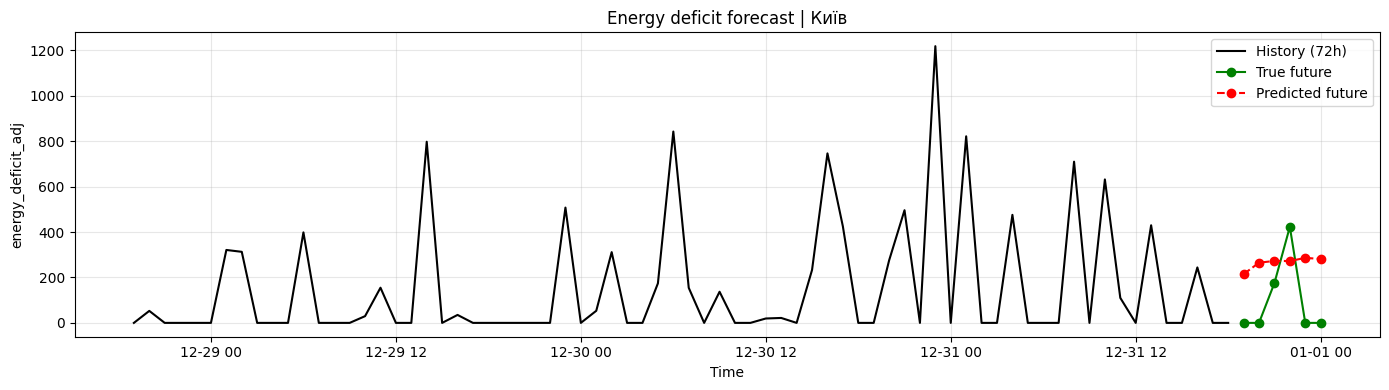

In [84]:
plt.figure(figsize=(14, 4))

# 72h history
plt.plot(
    time_hist,
    X_hist,
    label="History (72h)",
    color="black"
)

# true future
plt.plot(
    time_fut,
    Y_true[:, r_idx],
    marker="o",
    label="True future",
    color="green"
)

# predicted future
plt.plot(
    time_fut,
    Y_pred[:, r_idx],
    marker="o",
    linestyle="--",
    label="Predicted future",
    color="red"
)

plt.title(f"Energy deficit forecast | {REGION_NAME}")
plt.xlabel("Time")
plt.ylabel("energy_deficit_adj")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
